<a href="https://colab.research.google.com/github/Prajay404/QCNNFORQSO/blob/main/SMBH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 86.0 MB/s eta 0:00:00


Epoch [10/100], Loss: 55.9529, Accuracy: 0.0000, F1 Score: 0.0000
Epoch [20/100], Loss: 48.7318, Accuracy: 1.0000, F1 Score: 1.0000
Epoch [30/100], Loss: 42.2592, Accuracy: 1.0000, F1 Score: 1.0000
Epoch [40/100], Loss: 36.4843, Accuracy: 1.0000, F1 Score: 1.0000
Epoch [50/100], Loss: 31.3567, Accuracy: 1.0000, F1 Score: 1.0000
Epoch [60/100], Loss: 26.8268, Accuracy: 1.0000, F1 Score: 1.0000
Epoch [70/100], Loss: 22.8462, Accuracy: 1.0000, F1 Score: 1.0000
Epoch [80/100], Loss: 19.3679, Accuracy: 1.0000, F1 Score: 1.0000
Epoch [90/100], Loss: 16.3460, Accuracy: 1.0000, F1 Score: 1.0000
Epoch [100/100], Loss: 13.7368, Accuracy: 1.0000, F1 Score: 1.0000
Mean Squared Error: 14.5227
Accuracy: 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[20]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


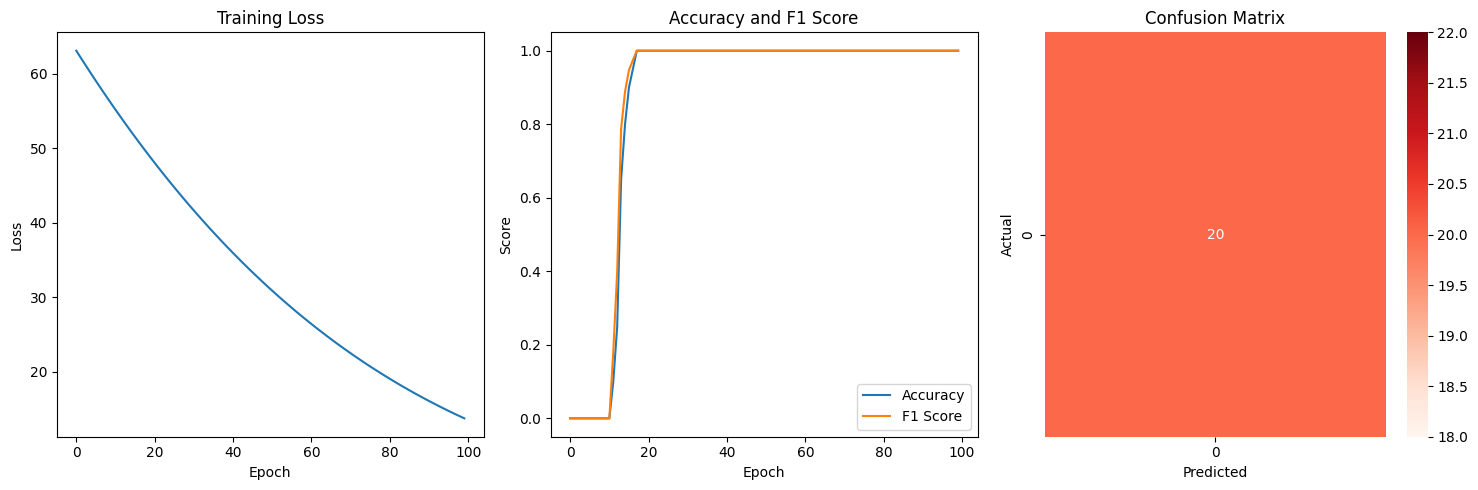

In [ ]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import pennylane as qml
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('/content/galaxy_data (2).csv')

# Use all columns except 'black_hole_mass' as features
features = [col for col in df.columns if col != 'black_hole_mass']
X = df[features]
y = df['black_hole_mass']

# Preprocess the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Define the quantum device
n_qubits = len(features)  # One qubit for each feature
dev = qml.device("default.qubit", wires=n_qubits)

# Define the quantum circuit
@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define the QCNN model
class QCNN(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super().__init__()
        self.n_qubits = n_qubits
        self.q_layers = nn.Parameter(torch.randn(n_layers, n_qubits, 3))
        self.fc = nn.Linear(n_qubits, 1)

    def forward(self, x):
        x = torch.tensor([quantum_circuit(x_i, self.q_layers) for x_i in x], dtype=torch.float32)
        return self.fc(x)

# Initialize the model
model = QCNN(n_qubits=n_qubits, n_layers=2)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Initialize lists to store metrics
losses = []
accuracies = []
f1_scores = []

# Training loop
n_epochs = 100
batch_size = 16
threshold = 0.8

for epoch in range(n_epochs):
    epoch_loss = 0
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Calculate metrics
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        y_pred_binary = (y_pred > threshold).float()
        y_test_binary = (y_test > threshold).float()
        accuracy = accuracy_score(y_test_binary, y_pred_binary)
        f1 = f1_score(y_test_binary, y_pred_binary)

    losses.append(epoch_loss / (len(X_train) // batch_size))
    accuracies.append(accuracy)
    f1_scores.append(f1)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss/(len(X_train)//batch_size):.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')

# Final evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    mse = criterion(y_pred, y_test)
    print(f'Mean Squared Error: {mse.item():.4f}')

y_pred_binary = (y_pred > threshold).float()
y_test_binary = (y_test > threshold).float()
accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f'Accuracy: {accuracy:.4f}')

f1 = f1_score(y_test_binary, y_pred_binary)
print(f'F1 Score: {f1:.4f}')

cm = confusion_matrix(y_test_binary, y_pred_binary)
print('Confusion Matrix:')
print(cm)

# Visualizations
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(131)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Accuracy and F1 Score plot
plt.subplot(132)
plt.plot(accuracies, label='Accuracy')
plt.plot(f1_scores, label='F1 Score')
plt.title('Accuracy and F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

# Confusion Matrix
plt.subplot(133)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

Epoch [10/200], Train Loss: 55.0184, Val Loss: 53.6824
Epoch [20/200], Train Loss: 37.4660, Val Loss: 36.4977
Epoch [30/200], Train Loss: 14.4683, Val Loss: 12.9648
Epoch [40/200], Train Loss: 2.0243, Val Loss: 1.0333
Epoch [50/200], Train Loss: 1.8931, Val Loss: 0.4547
Epoch [60/200], Train Loss: 1.7194, Val Loss: 0.5129
Epoch [70/200], Train Loss: 2.4915, Val Loss: 0.5200
Epoch [80/200], Train Loss: 1.8613, Val Loss: 0.5201
Epoch [90/200], Train Loss: 1.7738, Val Loss: 0.5198
Epoch [100/200], Train Loss: 1.9978, Val Loss: 0.5196
Epoch [110/200], Train Loss: 1.7496, Val Loss: 0.5196
Epoch [120/200], Train Loss: 1.8186, Val Loss: 0.5195
Epoch [130/200], Train Loss: 1.6697, Val Loss: 0.5194
Epoch [140/200], Train Loss: 1.4793, Val Loss: 0.5194
Epoch [150/200], Train Loss: 1.5716, Val Loss: 0.5194
Epoch [160/200], Train Loss: 1.7340, Val Loss: 0.5194
Epoch [170/200], Train Loss: 2.3855, Val Loss: 0.5194
Epoch [180/200], Train Loss: 1.7602, Val Loss: 0.5194
Epoch [190/200], Train Loss: 1.

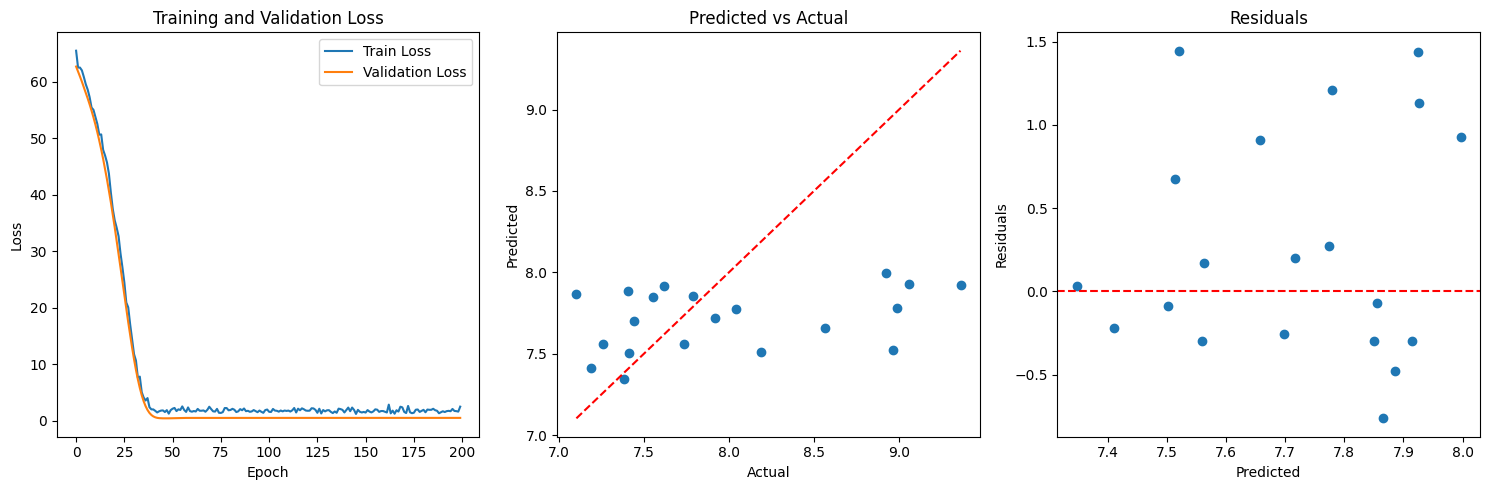

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pennylane as qml
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the data
df = pd.read_csv('/content/galaxy_data (2).csv')
features = [col for col in df.columns if col != 'black_hole_mass']
X = df[features]
y = df['black_hole_mass']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the quantum device
n_qubits = len(features)
dev = qml.device("default.qubit", wires=n_qubits)

# Define an enhanced quantum circuit
@qml.qnode(dev)
def quantum_circuit(inputs, weights1, weights2):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights1, wires=range(n_qubits))
    qml.IQPEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights2, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define an enhanced QCNN model
class EnhancedQCNN(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super().__init__()
        self.n_qubits = n_qubits
        self.q_layers1 = nn.Parameter(torch.randn(n_layers, n_qubits, 3))
        self.q_layers2 = nn.Parameter(torch.randn(n_layers, n_qubits, 3))
        self.fc1 = nn.Linear(n_qubits, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.tensor([quantum_circuit(x_i, self.q_layers1, self.q_layers2) for x_i in x], dtype=torch.float32)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)

# Initialize the model
model = EnhancedQCNN(n_qubits=n_qubits, n_layers=3)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

# Training loop
n_epochs = 200
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        val_losses.append(val_loss.item())

    scheduler.step(val_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

# Final evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error: {mse:.4f}')
    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'R2 Score: {r2:.4f}')

# Visualizations (same as before)
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(132)
plt.scatter(y_test.numpy(), y_pred.numpy())
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Predicted vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.subplot(133)
residuals = y_test.numpy() - y_pred.numpy()
plt.scatter(y_pred.numpy(), residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()
